In [8]:
import os, sys
LibPath = '../'
if LibPath in sys.path:
    print('YES')
else:
    print('NO, we\'ll add it now')
    sys.path.append(LibPath)
import warnings
warnings.filterwarnings("ignore")

YES


In [9]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from random import shuffle
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, fcluster, leaders, ClusterNode
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from Libraries.Util import Norm01, MovingAverage, RemTrend
from Libraries.graph import AdjMatr, TransMatr, GraphEntropy
from Libraries.features import  CEmbDim #CCorrent, CHurst,

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [11]:
def make_traject(row):
    mindist=.03
    demb=8  #CEmbDim(row)# В локальной версии можно рассчитывать #from Libraries.features import CCorrent, CHurst, CEmbDim
    depth=demb#*2+1
    traject=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
    traject['step']=np.arange(len(row)-depth)
    for i in range(len(row)-depth):
        traject.loc[i, traject.columns[1:]]=row[i:i+depth]
    '''матрица связей для кластеризации'''
    link = linkage(traject[traject.columns[1:]], 'ward', 'euclidean')
    '''оптимальное расстояние для кластеризации'''
    dist = link[:, 2]
    dist_rev = dist[::-1]
    i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*mindist))[0][0]
    d=dist_rev[i]
    '''кластеризация'''
    traject['cluster']=fcluster(link, d, criterion='distance')
    traject['cluster']=[list(traject['cluster'].drop_duplicates().values).index(i)+1 for i in traject['cluster']]
    traject['cluster']=traject['cluster'].astype(int)
    '''делание графа''' 
    return traject
def make_gr(traject):
    nod=traject['cluster'].values
    G=nx.DiGraph()
    clu=traject['cluster'].unique() 
    nodes=[i for i in zip(clu, [{'points':len(traject[traject.cluster==c])/len(traject), #node capacity
                                 'mean':np.mean(traject[traject.cluster==c]['t-0'].values)} for c in clu])] #mean value of the data in the node
    #np.asarray(list(nx.degree_centrality(G).values()))
    G.add_nodes_from(nodes)
    r=[(nod[j], nod[j+1]) for j in range(len(traject)-1)]
    c=[r.count(i) for i in r]
    G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(traject)-1)])
    return G
def show_gr(G):
    fig=plt.figure(figsize=(7, 7))
    lnd=G.number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    nx.draw(G, pos=nx.shell_layout(G, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    #nx.spectral_layout(G), random, circular
    fig.tight_layout()
    plt.show()
    return 0

In [12]:
ds=pd.read_csv('artdata_1000.csv')
ds

,t,000,001,002,003,004,005,006,007,008,...,990,991,992,993,994,995,996,997,998,999
0,0,0.200000,0.200000,0.200000,0.200000,0.200482,0.202545,0.200543,0.202054,0.205929,...,0.866122,0.649513,0.333150,0.703060,0.940617,0.009029,0.599111,0.168570,0.129886,0.734205
1,1,0.260337,0.260337,0.260337,0.260337,0.260710,0.262667,0.260693,0.262096,0.265751,...,0.908652,0.640843,0.363166,0.750696,0.997029,0.001046,0.583546,0.116514,0.086301,0.724486
2,2,0.320063,0.320063,0.320063,0.320063,0.320280,0.322056,0.320117,0.321595,0.325106,...,0.934933,0.665507,0.356261,0.776824,0.923966,0.017329,0.606290,0.179704,0.103170,0.745012
3,3,0.378571,0.378571,0.378571,0.378571,0.378456,0.380108,0.378335,0.380094,0.383261,...,0.941699,0.677883,0.407456,0.810320,0.861631,0.042103,0.604748,0.159807,0.075890,0.733275
4,4,0.435269,0.435269,0.435269,0.435269,0.435137,0.436532,0.434730,0.436384,0.439805,...,0.894942,0.643097,0.435345,0.828033,0.891476,0.081389,0.638462,0.167049,0.113257,0.774902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.435269,0.435269,0.435269,0.435269,0.433664,0.434468,0.434958,0.436222,0.434618,...,0.523453,0.155611,0.793299,0.090298,0.551612,0.559820,0.726068,0.517497,0.267537,0.716003
496,496,0.378571,0.378571,0.378571,0.378571,0.377338,0.377828,0.378640,0.379535,0.378712,...,0.568935,0.178591,0.775095,0.106035,0.581839,0.537680,0.747879,0.461279,0.305500,0.707708
497,497,0.320063,0.320063,0.320063,0.320063,0.318980,0.319484,0.320297,0.321480,0.320921,...,0.581972,0.170990,0.754697,0.057452,0.513601,0.486238,0.722791,0.503879,0.347248,0.704792
498,498,0.260337,0.260337,0.260337,0.260337,0.259482,0.260102,0.260787,0.261976,0.261640,...,0.613724,0.173882,0.705824,0.046649,0.440846,0.511512,0.731909,0.458787,0.348476,0.666617


In [15]:
'''делание графов'''
nG=[]
for c in tqdm(ds.columns[1:]):
#     if c<'165': l=0
#     elif c<'330': l=1
#     else: l=2
    if c<'300': l=0
    elif c<'700': l=1
    else: l=2
    row=ds[c].values
    #row=RemTrend(row)[0]
    traject=make_traject(row)
    G=make_gr(traject)
    tG=from_networkx(G, group_node_attrs=['points','mean'], group_edge_attrs=all) 
    cent=np.asarray(list(nx.degree_centrality(G).values()))# degree_centrality to node features
    cent=torch.tensor(cent.reshape(len(cent),1), dtype=float)
    tG.x=torch.cat((tG.x, cent),1) #node centrality to feture list
    tG.x=tG.x.float()
    tG.y=torch.tensor([l])
    nG.append(tG)
print('Done!', len(nG))
#trmat=TransMatr(G0, paint=True) #from Libraries.graph import AdjMatr, TransMatr

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:01<00:00,  1.67it/s]


Done! 1000


In [16]:
batch=25
loader = DataLoader(nG.copy(), batch_size=batch, shuffle=True)
dataset=loader.dataset
print()
#print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')

d = dataset[0]  # Get the first graph object.

print()
print(d)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {d.num_nodes}')
print(f'Number of edges: {d.num_edges}')
print(f'Average node degree: {d.num_edges / d.num_nodes:.2f}')
print(f'Has isolated nodes: {d.has_isolated_nodes()}')
print(f'Has self-loops: {d.has_self_loops()}')
print(f'Is undirected: {d.is_undirected()}')


Number of graphs: 1000

Data(edge_index=[2, 26], x=[13, 3], edge_attr=[26, 1], y=[1])
Number of nodes: 13
Number of edges: 26
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [17]:
shuffle(dataset)
train_dataset = dataset[:750]
test_dataset = dataset[750:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(train_dataset, batch_size=35, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=35, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Number of training graphs: 750
Number of test graphs: 250
Step 1:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 945], x=[384, 3], edge_attr=[945, 1], y=[35], batch=[384], ptr=[36])

Step 2:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 911], x=[356, 3], edge_attr=[911, 1], y=[35], batch=[356], ptr=[36])

Step 3:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 942], x=[377, 3], edge_attr=[942, 1], y=[35], batch=[377], ptr=[36])

Step 4:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 940], x=[362, 3], edge_attr=[940, 1], y=[35], batch=[362], ptr=[36])

Step 5:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 974], x=[374, 3], edge_attr=[974, 1], y=[35], batch=[374], ptr=[36])

Step 6:
Number of graphs in the current batch: 35
DataBatch(edge_index=[2, 901], x=[354, 3], edge_attr=[901, 1], y=[35], batch=[354], ptr=[36])

Step 7:
Number of graphs in the current batch: 35
DataBatch(edge_index=[

In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(3, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 3)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64)#.to(device)
#data = dataset[0].to(device)
print(model)

GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
def train(train_loader):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def predict(data):
    model.eval()
    out = model(data.x, data.edge_index, torch.tensor([0]))  
    pred = out.argmax(dim=1)[0:1]
    return pred

acc=[]
for epoch in range(101):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    acc.append((train_acc, test_acc))
    if epoch%10==0:
        print(f'Epoch: {epoch:3d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:   0, Train Acc: 0.6747, Test Acc: 0.6160
Epoch:  10, Train Acc: 0.7800, Test Acc: 0.7560
Epoch:  20, Train Acc: 0.8027, Test Acc: 0.7520
Epoch:  30, Train Acc: 0.8187, Test Acc: 0.7880
Epoch:  40, Train Acc: 0.8267, Test Acc: 0.8360
Epoch:  50, Train Acc: 0.8107, Test Acc: 0.8000
Epoch:  60, Train Acc: 0.8547, Test Acc: 0.8600
Epoch:  70, Train Acc: 0.8467, Test Acc: 0.8560
Epoch:  80, Train Acc: 0.8320, Test Acc: 0.8560
Epoch:  90, Train Acc: 0.8600, Test Acc: 0.9040
Epoch: 100, Train Acc: 0.8747, Test Acc: 0.8880


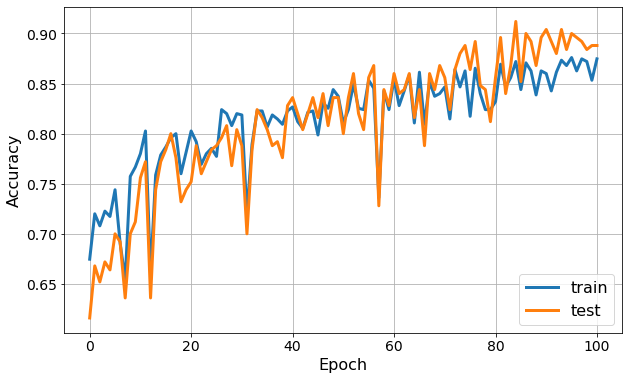

In [20]:
plt.figure(figsize=(10,6), facecolor='w') 
plt.plot(acc, label=['train','test'], lw=3)
plt.legend(loc=4, fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Epoch', size=16)
plt.ylabel('Accuracy', size=16)
plt.grid()
plt.show()

In [22]:
files=os.listdir('Weekly_data/')

DGS30.csv Index(['DATE', 'DGS30'], dtype='object')


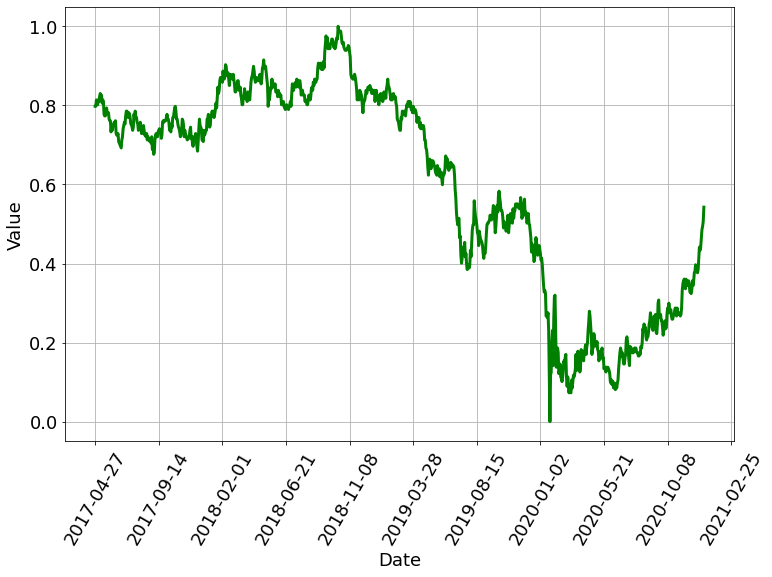

In [24]:
f=files[16]
real=pd.read_csv('Weekly_data/'+f)[:1001]
print(f, real.columns)
smooth=7
ser=real[real.columns[1]].values
ser=np.delete(ser, np.where(ser=='.'))
ser=ser.astype(float)

# #ser=MovingAverage(ser, numb=len(ser)//smooth)[smooth+5:-3]
ser=Norm01(ser)[0]
bound=150
row=ser[:bound]
t=np.arange(len(ser))
plt.figure(figsize=(12,8), facecolor='w') 
#plt.title(gr.upper(), size=20)
plt.plot(ser, lw=3, c='g', label='For incremental learning')
#plt.plot(row, lw=3, label='Initial series')
# plt.plot(x+data.mean())
# plt.plot(t, a*t+b)
xt=np.arange(0, 1001, 100)
plt.xticks(xt,real[real.columns[0]].values[xt], size=18, rotation=60)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('Date', size=18)
plt.ylabel('Value', size=18)
#plt.legend(fontsize=14)
plt.grid(axis='both')
#plt.savefig('Nreal_NUGLCBW027NBOG_class.png', dpi=300, format='png' )
plt.show()

In [25]:
'''Initial Graph'''
traject=make_traject(row)
G=make_gr(traject)
tG=from_networkx(G, group_node_attrs=['points', 'mean'], group_edge_attrs=all) 
cent=np.asarray(list(nx.degree_centrality(G).values()))# degree_centrality to node features
cent=torch.tensor(cent.reshape(len(cent),1), dtype=float)
tG.x=torch.cat((tG.x, cent),1) 
tG.x=tG.x.float()
pred = predict(tG)
int(pred), len(G.nodes)

(2, 10)

In [32]:
from Libraries.Spectrum import MSSAExplore
from Libraries.Localapp import LAprExplore
from Libraries.ChooChoo import ChooChooExplore
'''Graph is growing'''
labels=[int(pred)]
st=60
mape=[MSSAExplore(pd.DataFrame({'data':ser[:bound+st]}),st,st,prds=[], predictors=None)[2]]
print(mape)                
centres=ages={}
depth=25
dist=.05
for c in traject.cluster.unique():
    centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)
    ages[c]=0
for k in range(bound,len(ser)-st,st):
    print(st)
    #trj=make_traject(Norm01(ser[k-depth:k+st])[0])
    trj=make_traject(ser[k-depth:k+st])
    trj.drop('cluster', axis=1, inplace=True)
    trj.step=trj.step.values+k
    for i in range(st): 
        step=trj.loc[i, trj.columns[1:]].values
        norms=[np.linalg.norm(step-centres[j]) for j in centres.keys()]
        if min(norms) <= dist:
            newclust=list(centres.keys())[norms.index(min(norms))]
            added=False
        else:
            newclust=traject.cluster.max()+1 
            added=True
            ages[newclust]=0
        traject=traject.append(trj.loc[i],ignore_index=True)
        traject.loc[traject.step==trj.loc[i].step, 'cluster']=newclust
        traject.cluster=traject.cluster.astype(int)
        if added: 
            oldest=max(ages, key=ages.get)
            traject.drop(traject[traject.cluster==oldest].index, inplace=True)
            del ages[oldest]
        centres={}
        for c in traject.cluster.unique():
            centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)
            ages[c]+=1
    traject.cluster=traject.cluster.astype(int)
    G=make_gr(traject)
    tG=from_networkx(G, group_node_attrs=all, group_edge_attrs=all) 
    cent=np.asarray(list(nx.degree_centrality(G).values()))# degree_centrality to node features
    cent=torch.tensor(cent.reshape(len(cent),1), dtype=float)
    tG.x=torch.cat((tG.x, cent),1) 
    tG.x=tG.x.float()
    pred = predict(tG)
    labels.append(int(pred[0]))
    err=min(MSSAExplore(pd.DataFrame({'data':ser[k-bound:k+st]}),st,st,prds=[], predictors=None)[2],
           #LAprExplore(pd.DataFrame({'data':ser[k-bound:k+st]}),st,st,prds=[], predictors=None)[2],
           ChooChooExplore(pd.DataFrame({'data':ser[k-bound:k+st]}),st,st,prds=[], predictors=None)[2])
    mape.append(err)
    print(k, int(pred[0]), mape[-1])

[6.993499899595139]
60
150 0 6.993499899595139
60
210 0 8.793073301369951
60
270 0 8.265738181198332
60
330 0 8.436323407140895
60
390 0 17.380652467336628
60
450 0 10.114510752254985
60
510 0 18.02586784017119
60
570 0 12.66737594725208
60
630 0 19.585786986112826
60
690 2 200.94434437610795
60
750 2 47.27882269580334
60
810 2 23.86991273416873
60
870 1 25.18104842655486


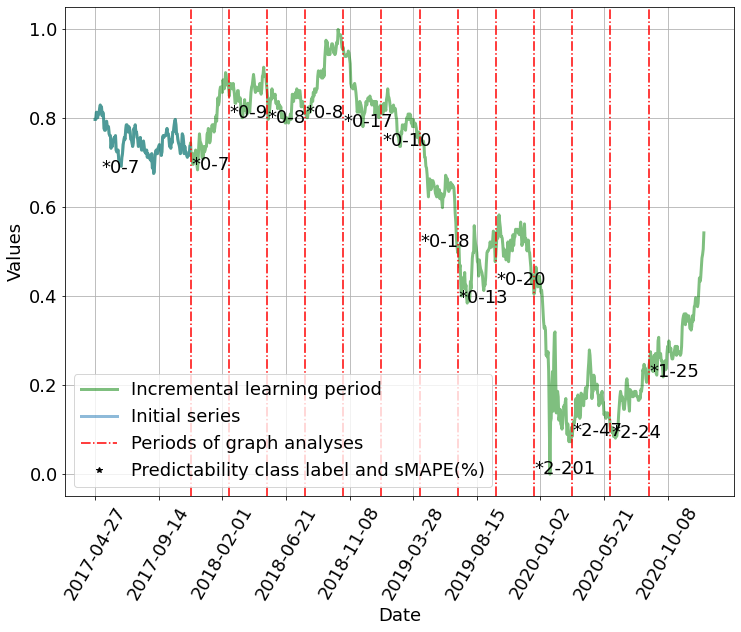

class 0 - mean sMAPE 11.7%
class 1 - mean sMAPE 25.2%
class 2 - mean sMAPE 90.7%


In [33]:
row=ser[:bound]
t=np.arange(len(ser))
plt.figure(figsize=(12,9), facecolor='w') 
plt.plot(ser, lw=3, c='g', label='Incremental learning period', alpha=.5)
plt.plot(row, lw=3, label='Initial series', alpha=.5)
j=0
plt.text(10, min(ser[:bound]), '*%i-%.0f'%(labels[j], mape[j]), size=18, c='k')
for k in range(bound,len(ser)-st,st):
    j+=1
    plt.text(k+1, min(ser[k:k+st]), '*%i-%.0f'%(labels[j], mape[j]), size=18, c='k')
    plt.axvline(k, ls='-.', c='r')
plt.plot([], ls='-.', c='r', label='Periods of graph analyses')
plt.plot([], '*', c='k', label='Predictability class label and sMAPE(%)')
#xt=np.arange(smooth, len(ser)+1, 21)
#plt.xticks(xt-smooth, real.date.values[xt], size=14, rotation=90)
xt=np.arange(0, 1000, 100)
plt.xticks(xt,real[real.columns[0]].values[xt], size=18, rotation=60)
plt.yticks(size=18)
plt.xlabel('Date', size=18)
plt.ylabel('Values', size=18)
plt.legend(fontsize=18, loc=3)
plt.grid(axis='both')
#plt.savefig('real_OG_class.png', dpi=300, format='png' )
plt.show()
res=pd.DataFrame({'l':labels, 'm':mape})
for i in (0,1,2):
    print('class %i - mean sMAPE %.1f%%'%(i, res[res.l==i].m.mean()))

In [34]:
from scipy.stats import mannwhitneyu
m0, m1, m2 = res[res.l==0].m.values, res[res.l==1].m.values, res[res.l==2].m
U1, p = mannwhitneyu(m0, m1, use_continuity=True)
U2=len(m0)*len(m1)-U1
min(U1, U2), p, len(m0), len(m1)

(0.0, 0.07689518696054243, 10, 1)